In [150]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model
from sklearn.cross_decomposition import PLSRegression
import pandas as pd

In [151]:
np.random.seed(42)  # Setting a seed for reproducibility

# Generate random data
size = 200  # You can change the size of the arrays as needed
c_a = np.random.uniform(0, 1, size)
c_b = np.random.uniform(0, 1, size)
c_c = 1 - c_a - c_b

# Ensure that the values are non-negative
c_a = np.clip(c_a, 0, None)
c_b = np.clip(c_b, 0, None)
c_c = np.clip(c_c, 0, None)

# Normalize to ensure the sum is 1 for each index
total = c_a + c_b + c_c
c_a /= total
c_b /= total
c_c /= total

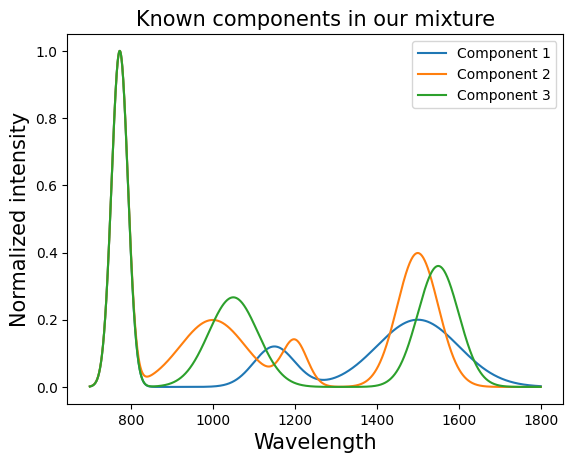

In [152]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(700, 1800, 2000)
# First component
mu_a1 = 773
sigma_a1 = 20
intensity_a1 = 1

mu_a2 = 1150
sigma_a2 = 50
intensity_a2 = 0.3

mu_a3 = 1500
sigma_a3 = 100
intensity_a3 = 1

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 773
sigma_b1 = 20
intensity_b1 = 1

mu_b2 = 1000
sigma_b2 = 80
intensity_b2 = 0.8

mu_b3 = 1200
sigma_b3 = 30
intensity_b3 = 0.2

mu_b4 = 1500
sigma_b4 = 50
intensity_b4 = 1

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 773
sigma_c1 = 20
intensity_c1 = 1

mu_c2 = 1050
sigma_c2 = 60
intensity_c2 = 0.8

mu_c3 = 1550
sigma_c3 = 50
intensity_c3 = 0.9

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2) + Gauss(x_range, mu_c3, sigma_c3, intensity_c3)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

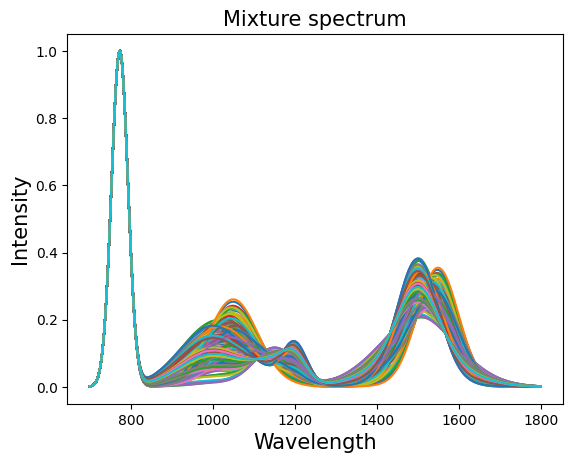

In [153]:
# Mixture
mixture = np.array([c_a, c_b, c_c]).T @ np.array([component_a, component_b, component_c])
# How does it look?
plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()


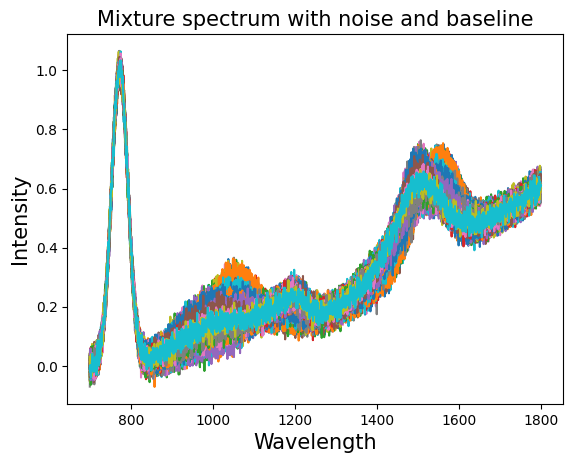

In [154]:
# Let's add some noise for a bit of realism:

# Random noise:
mixture += np.random.normal(0, 0.02, size = mixture.shape)

# Baseline:

# Baseline as a polynomial background:
poly = 0.001 * np.ones(len(x_range)) + 0.000001 * x_range + 0.0000005 * (x_range - 700)**2
mixture += poly


plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum with noise and baseline', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [155]:
# Estimation of the baseline:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.0009 # asymmetry
estimated_baselined = []
for i in range(mixture.shape[0]):
    estimated_baselined.append(baseline_als(mixture[i], l, p))
estimated_baselined = np.array(estimated_baselined).T

# Baseline subtraction:
baselined_spectrum = mixture.T - estimated_baselined

# Reasoning baseline + noise


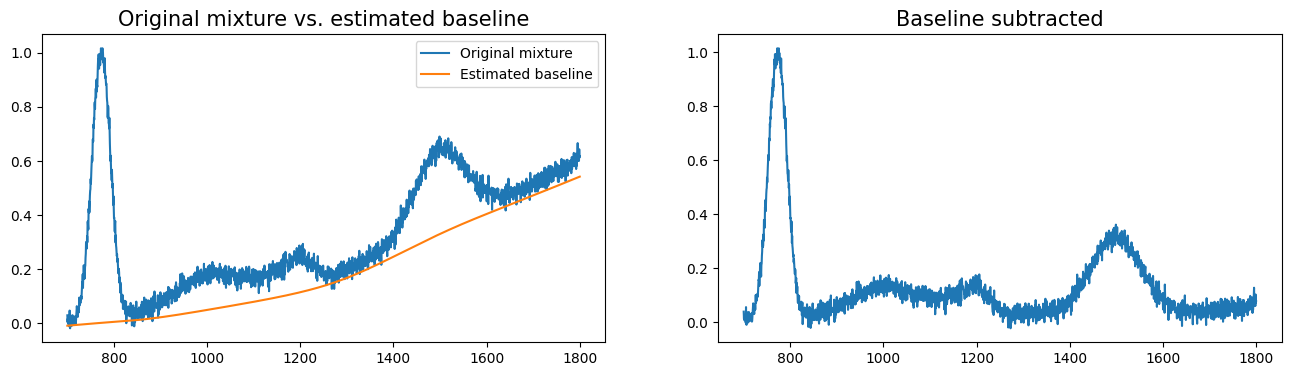

In [156]:
# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(x_range, mixture[0].T, label = 'Original mixture')
ax1.plot(x_range, estimated_baselined[:,0], label = 'Estimated baseline')
ax1.set_title('Original mixture vs. estimated baseline', fontsize = 15)

# We compared the original mix spectrum and the estimated baseline:

ax2.plot(x_range, baselined_spectrum[:,0], label = 'Baseline subtracted')
ax2.set_title('Baseline subtracted', fontsize = 15)

ax1.legend()
plt.show()

In [157]:
# Parameters:
w = 100 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = []
for i in range(baselined_spectrum.shape[1]):
    smoothed_spectrum.append(savgol_filter(baselined_spectrum[:,i], w, polyorder = p, deriv=0))
smoothed_spectrum = np.array(smoothed_spectrum)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/

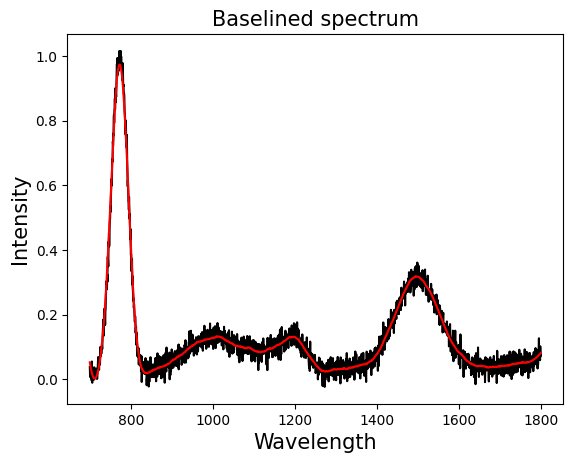

In [158]:
# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum[:,0], color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum[0], color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [159]:
np.array([c_a, c_b, c_c]).T.shape, smoothed_spectrum.shape

((200, 3), (200, 2000))

In [160]:
# Splitting the data into train, validation and test sets:
X_train = smoothed_spectrum[:150]
X_val = smoothed_spectrum[150:175]
X_test = smoothed_spectrum[175:]

concentrations = np.array([c_a, c_b, c_c]).T
y_train = concentrations[:150]
y_val = concentrations[150:175]
y_test = concentrations[175:]

In [161]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape

((150, 2000), (25, 2000), (150, 3), (25, 3), (25, 2000), (25, 3))

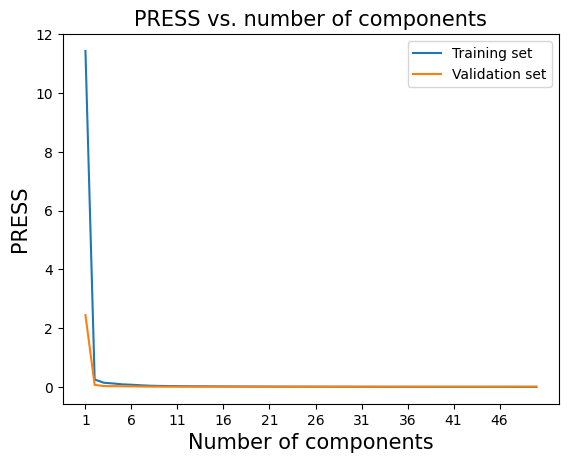

In [162]:
# Find best number of components using PRESS and cross-validation
# Parameters:
n_components = 50 # number of components to test
press_train = []
press_val = []

for i in range(1, n_components + 1):
    pls = PLSRegression(n_components = i)
    pls.fit(X_train, y_train)
    y_pred_train = pls.predict(X_train)
    y_pred_val = pls.predict(X_val)
    press_train.append(np.sum((y_pred_train - y_train)**2))
    press_val.append(np.sum((y_pred_val - y_val)**2))
    
# Plotting the PRESS values for the training and validation sets:
plt.plot(range(1, n_components + 1), press_train, label = 'Training set')
plt.plot(range(1, n_components + 1), press_val, label = 'Validation set')
plt.xlabel('Number of components', fontsize = 15)
plt.ylabel('PRESS', fontsize = 15)
plt.title('PRESS vs. number of components', fontsize = 15)
plt.xticks(range(1, n_components + 1, 5))
plt.legend()
plt.show()


In [163]:
best_n_components = np.argmin(press_val) + 1
print('The best number of components is:', best_n_components)


The best number of components is: 22


In [164]:
pls = PLSRegression(n_components = best_n_components)
pls.fit(X_train, y_train)
y_pred_train = pls.predict(X_train)
y_pred_val = pls.predict(X_val)
y_pred_test = pls.predict(X_test)

y_pred_train = np.clip(y_pred_train, 0, None)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_test = np.clip(y_pred_test, 0, None)

In [165]:
# Evaluation metrics:
# RMSE:
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
rmse_val = np.sqrt(np.mean((y_pred_val - y_val)**2))
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))

# MAE:
mae_train = np.mean(np.abs(y_pred_train - y_train))
mae_val = np.mean(np.abs(y_pred_val - y_val))
mae_test = np.mean(np.abs(y_pred_test - y_test))

df = pd.DataFrame({'RMSE': [rmse_train, rmse_val, rmse_test], 'MAE': [mae_train, mae_val, mae_test]}, index = ['Train', 'Validation', 'Test'])
df.round(3)

,RMSE,MAE
Train,0.005,0.004
Validation,0.009,0.007
Test,0.012,0.009


In [166]:
# Print some results:
y_test = np.round(y_test, 3)
y_pred_test = np.round(y_pred_test, 3)

df = pd.DataFrame({'Real concentration A': y_test[:,0], 'Predicted concentration A': y_pred_test[:,0], 'Real concentration B': y_test[:,1], 'Predicted concentration B': y_pred_test[:,1], 'Real concentration C': y_test[:,2], 'Predicted concentration C': y_pred_test[:,2]})
# Multi level column names:
df.columns = pd.MultiIndex.from_product([['Concentration A', 'Concentration B', 'Concentration C'], ['Real', 'Predicted']])
df

Concentration A           Concentration B           Concentration C  \
              Real Predicted            Real Predicted            Real   
0            0.174     0.205           0.319     0.300           0.507   
1            0.450     0.467           0.550     0.551           0.000   
2            0.387     0.380           0.023     0.012           0.590   
3            0.535     0.549           0.465     0.459           0.000   
4            0.138     0.149           0.282     0.273           0.581   
5            0.341     0.326           0.118     0.127           0.541   
6            0.113     0.095           0.697     0.711           0.190   
7            0.595     0.587           0.405     0.401           0.000   
8            0.500     0.475           0.500     0.529           0.000   
9            0.258     0.253           0.735     0.734           0.007   
10           0.451     0.439           0.549     0.561           0.000   
11           0.743     0.769           0.257     0.245           0.000   
12           0.555     0.587           0.177     0.160           0.267   
13           0.414     0.397           0.586     0.595           0.000   
14           0.231     0.228           0.769     0.766           0.000   
15           0.086     0.105           0.914     0.909           0.000   
16           0.685     0.670           0.315     0.323           0.000   
17           0.708     0.716           0.292     0.292           0.000   
18           0.449     0.437           0.551     0.564           0.000   
19           0.339     0.336           0.341     0.338           0.320   
20           0.273     0.261           0.727     0.731           0.000   
21           0.458     0.441           0.542     0.538           0.000   
22           0.677     0.685           0.323     0.316           0.000   
23           0.542     0.531           0.458     0.459           0.000   
24           0.508     0.506           0.492     0.490           0.000   

              
   Predicted  
0      0.495  
1      0.000  
2      0.608  
3      0.000  
4      0.578  
5      0.548  
6      0.194  
7      0.012  
8      0.000  
9      0.013  
10     0.000  
11     0.000  
12     0.253  
13     0.007  
14     0.005  
15     0.000  
16     0.006  
17     0.000  
18     0.000  
19     0.326  
20     0.008  
21     0.021  
22     0.000  
23     0.010  
24     0.004